In [1]:
!sudo apt-get install tesseract-ocr
!pip install pytesseract opencv-python jiwer
!pip install opendatasets

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 1 not upgraded.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 53.3 MB/s eta 0:00:00


In [2]:
import cv2
import numpy as np
import pytesseract
from jiwer import wer, cer
import matplotlib.pyplot as plt
import opendatasets as od
import os
import glob
import random
import json

In [3]:
dataset_url = 'https://www.kaggle.com/datasets/senju14/ocr-dataset-of-multi-type-documents'
od.download(dataset_url)

data_dir = './ocr-dataset-of-multi-type-documents'
print(f"Dataset downloaded to: {data_dir}")
print(f"Contents: {os.listdir(data_dir)}")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ananthan2024r
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/senju14/ocr-dataset-of-multi-type-documents


100%|██████████| 5.16G/5.16G [02:05<00:00, 44.1MB/s]



Dataset downloaded to: ./ocr-dataset-of-multi-type-documents
Contents: ['form', 'document', 'invoice', 'real_life']


In [21]:
def get_data_from_json(json_path):

    with open(json_path, 'r') as f:
      data = json.load(f)

    if 'form' in data and 'lines' in data:
      img_id = data['form']['id']
      all_lines = [line['text'] for line in data['lines'] if 'text' in line]
      ground_truth = " ".join(all_lines)
      return img_id, ground_truth
    else:
      return None, None

In [23]:
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    if img is None: return None, None

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,1))
    processed = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

    return img, processed


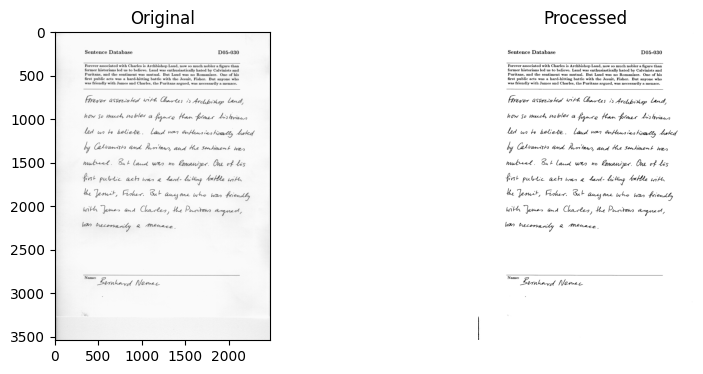

File:         d05-030.png
Ground Truth: Sentence Database D05-030 Forever associated with Charles is Archbishop Laud; now s0 much nobler a f...
OCR Output:   Sentence Database D05-030 Forever associated with Charles is Archbishop Laud, now so much nobler a f...
METRICS ->    CER: 0.3140 | WER: 0.5437
------------------------------------------------------------


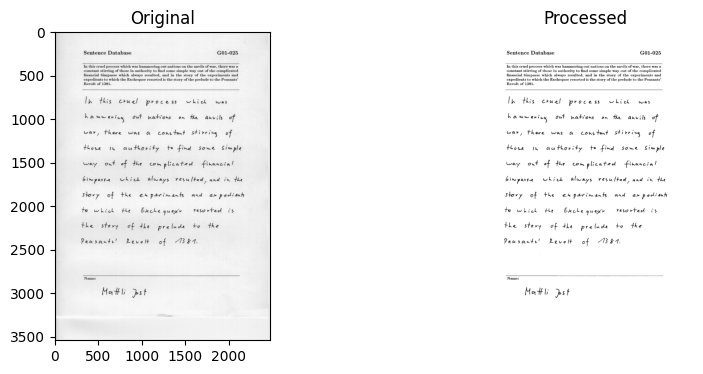

File:         g01-025.png
Ground Truth: Sentence Database G01-025 In this cruel process which was hammering out nations on the anvils of war...
OCR Output:   | Sentence Database G01-025 ‘In this cruel process which was hammering out nations on the anvils of ...
METRICS ->    CER: 0.2852 | WER: 0.5879
------------------------------------------------------------


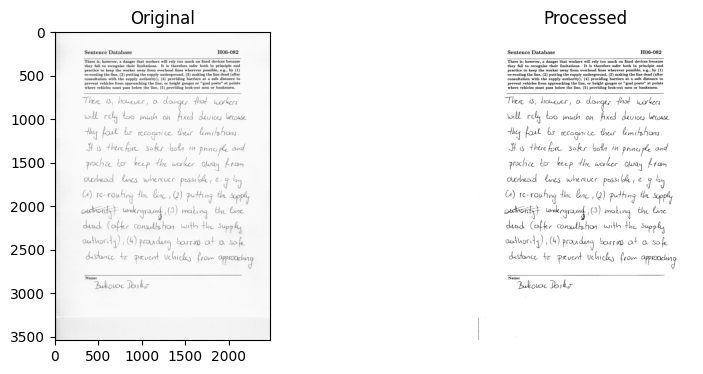

File:         h06-082.png
Ground Truth: Sentence Database H06-082 There is, however , a danger that workers will rely too much on fixed devi...
OCR Output:   Sentence Database H06-082 ‘There is, however, a danger that workers will rely too much on fixed devi...
METRICS ->    CER: 0.3210 | WER: 0.5820
------------------------------------------------------------


In [24]:

DATASET_ROOT = '/content/ocr-dataset-of-multi-type-documents'

all_json_files = glob.glob(f"{DATASET_ROOT}/**/*.json", recursive=True)

valid_samples_processed = 0
target_samples = 3


for json_path in all_json_files:
    if valid_samples_processed >= target_samples:
        break

    #Parse JSON
    img_id, ground_truth = get_data_from_json(json_path)
    if not img_id:
        continue # Skip this file if parser returned None

    #Find Image
    found_img_path = None
    for ext in ['png', 'jpg', 'jpeg', 'tif', 'bmp']:
        matches = glob.glob(f"{DATASET_ROOT}/**/{img_id}.{ext}", recursive=True)
        if matches:
            found_img_path = matches[0]
            break

    if not found_img_path:
        continue

    #Process & OCR
    original, processed = preprocess_image(found_img_path)
    if original is None: continue

    # Use PSM 6 for Block of text
    predicted_text = pytesseract.image_to_string(processed, config='--psm 6')

    #Metrics
    clean_truth = " ".join(ground_truth.split())
    clean_pred = " ".join(predicted_text.split())

    if not clean_pred.strip():
        c_err, w_err = 1.0, 1.0
    else:
        c_err = cer(clean_truth, clean_pred)
        w_err = wer(clean_truth, clean_pred)

    # Visualize
    valid_samples_processed += 1
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1); plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB)); plt.title("Original")
    plt.subplot(1, 2, 2); plt.imshow(processed, cmap='gray'); plt.title("Processed")
    plt.axis('off')
    plt.show()

    print(f"File:         {os.path.basename(found_img_path)}")
    print(f"Ground Truth: {clean_truth[:100]}...")
    print(f"OCR Output:   {clean_pred[:100]}...")
    print(f"METRICS :    CER: {c_err:.4f} | WER: {w_err:.4f}")
    print("-" * 60)